# 0.0 Imports

In [1]:
import math
import datetime
import inflection

import pandas              as pd
import numpy               as np
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as gridspec

from sklearn.metrics       import mean_absolute_error, mean_squared_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from IPython.display      import Image
from tabulate             import tabulate
from scipy                import stats as ss
from boruta               import BorutaPy

## 0.1 Helper Functions

In [2]:
def crammer_v (x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2_correct = max(0, chi2 - (k-1)*(r-1)/(n-1))
    k_correct = k - (k-1)**2/(n-1)
    r_correct = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2_correct/n)/(min(k_correct-1, r_correct-1)))


def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        
        if verbose:
            print('\nKFold Number: {}'.format(k))
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # trainig and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each KFolder iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)


# ============ merge ============ #

df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

### Notes ###
# merge é uma classe da biblioteca pandas, acessada através do ponto (.).
# how está identificando como esse merge vai acontecer, no caso, é conveniente deixar left, já que a tabela com mais
# informações está na esquerda e a com menos informações está na direita.
# Por fim, on indica a coluna comum entre as duas que será usada para fazer essa junção.



In [4]:
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## 1.1 Renomear Colunas

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']



snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

### Note ###
# A função map está fazendo um mapeamento da função snakecase em todas as palavras da lista cols_old
# Como retorno temos uma lista que é guardada na variável cols_new

#rename
df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Dimensão dos dados

In [8]:
print('Number of Rows: {}' .format(df1.shape[0]) )
print('Number of Columns: {}' .format(df1.shape[1]) )

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Datatypes

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check nos NAs

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year  
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval               
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [13]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [14]:
df1.sample(5).T

,629967,483592,567248,782391,101105
store,778,468,499,447,756
day_of_week,6,4,6,2,6
date,2013-12-14 00:00:00,2014-04-24 00:00:00,2014-02-08 00:00:00,2013-07-30 00:00:00,2015-05-02 00:00:00
sales,6486,4966,5385,6457,26312
customers,814,609,807,646,3676
open,1,1,1,1,1
promo,0,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,1,0
store_type,a,c,c,a,a


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 Descriptive Statistical

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### NOTE ###
# Separando as variáveis em categóricas e numéricas

### 1.7.1 Numerical atributes

In [18]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenar
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

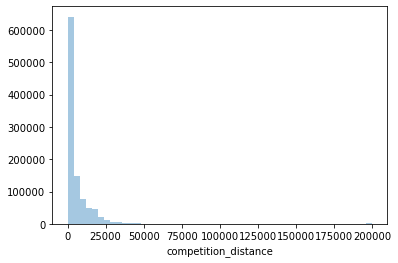

In [19]:
sns.distplot(df1['competition_distance'], kde=False)

### 1.7.2 Categorical atributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

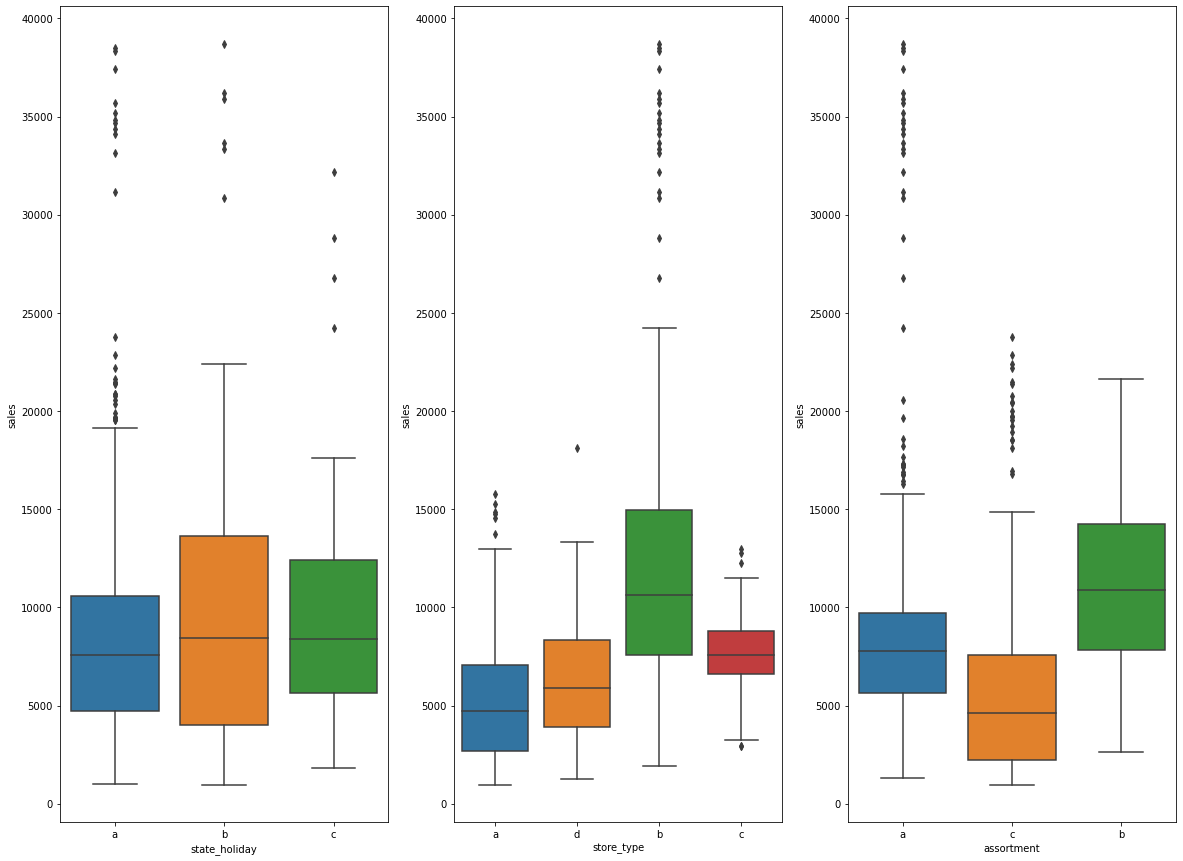

In [21]:
fig, ax = plt.subplots(figsize=(20,15))
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux);

# 2.0 PASSO 02 - FEATURE ENGINEERING

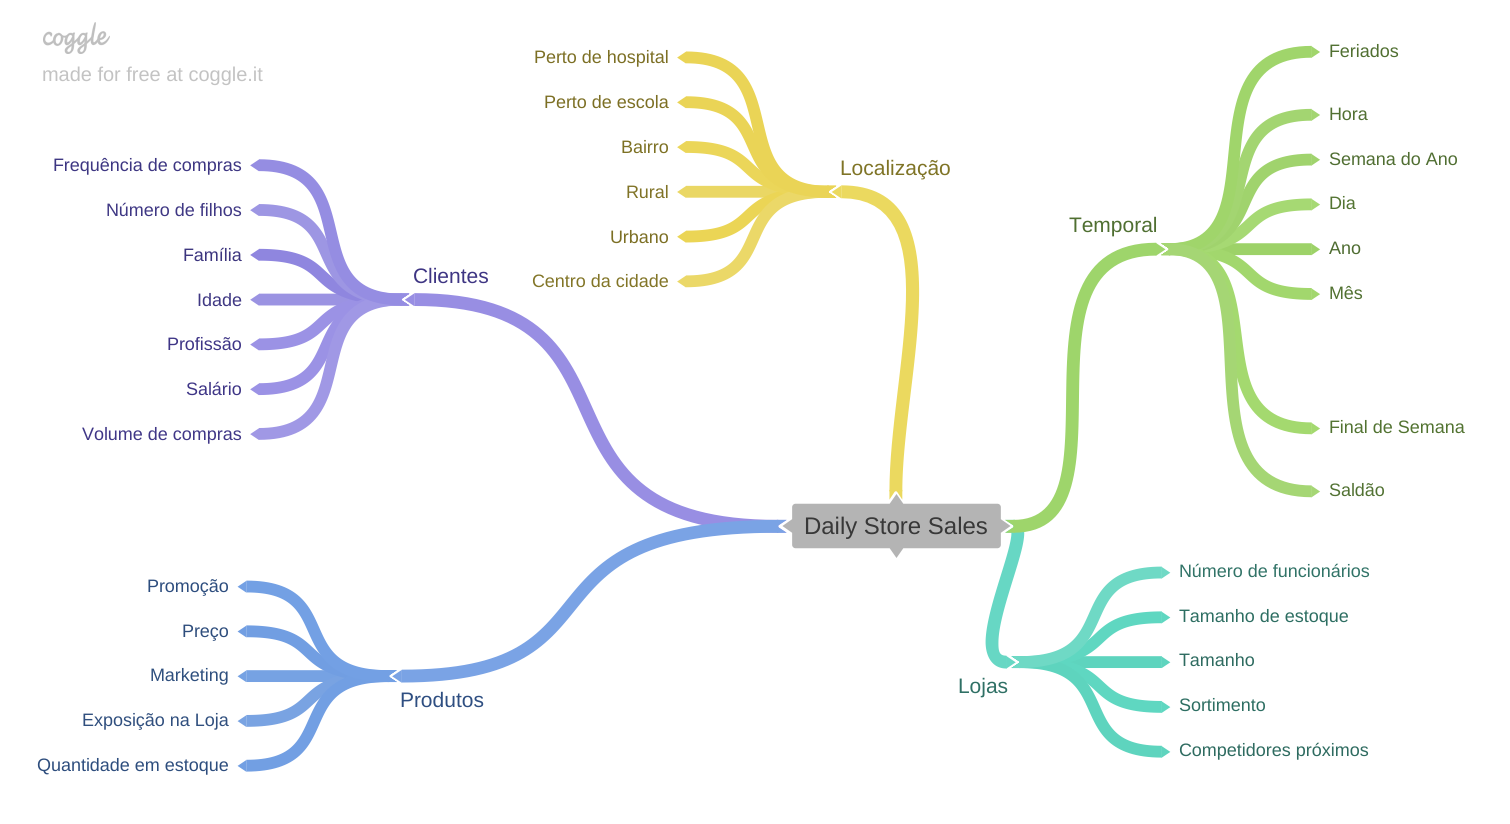

In [22]:
Image('images/Daily_Store_Sales.png')

## 2.1 Criação de Hipóteses

### 2.1.1 Hipóteses Loja

**1** Lojas com maior número de funcionários deveriam vender mais.

**2** Lojas com maior capacidade de estoque deveriam vender mais.

**3** Lojas com maior porte deveriam vender mais.

**4** Lojas com maior sortimento deveriam vender mais.

**5** Lojas com competidores mais próximos deveriam vender menos.

**6** Lojas com competidores a mais tempo deveriam vender mais.

### 2.1.1 Hipóteses Produto

**1** Lojas que investem mais em marketing deveriam vender mais.

**2** Lojas com maior exposição de produtos deveriam vender mais.

**3** Lojas com produtos com preço menor deveriam vender mais.

**4** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6** Lojas com mais dias de promoção deveriam vender mais.

**7** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.1 Hipóteses Tempo

**1** Lojas abertas durante o feriado de natal deveriam vender mais.

**2** Lojas deveriam vender mais ao longo dos anos.

**3** Lojas deveriam vender mais no segundo semestre do ano.

**4** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5** Lojas deveriam vender menos aos finais de semana.

**6** Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista Final de Hipóteses

## 2.3 Feature Engineering

In [23]:
df2 = df1.copy()

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype('int64')

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


C:\Users\User\AppData\Local\Temp\ipykernel_1344\2367785993.py:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [25]:
df2.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 3.0. PASSO 3 - FILTRAGEM DE VARIÁVEIS

In [26]:
df3 = df2.copy()

In [27]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das linhas

In [28]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das colunas

In [29]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4.0. PASSO 4 - ANÁLISE EXPLORATÓRIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response variable

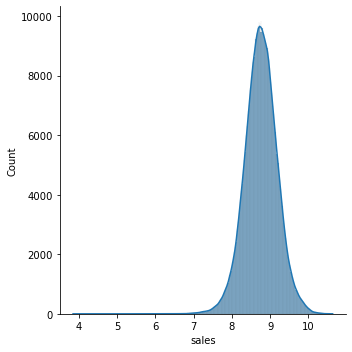

In [31]:
sns.displot(np.log1p(df4['sales']), kde=True)

### 4.1.2 Numerical variable

C:\Users\User\AppData\Local\Temp\ipykernel_1344\46414605.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(bins=25, ax=ax);


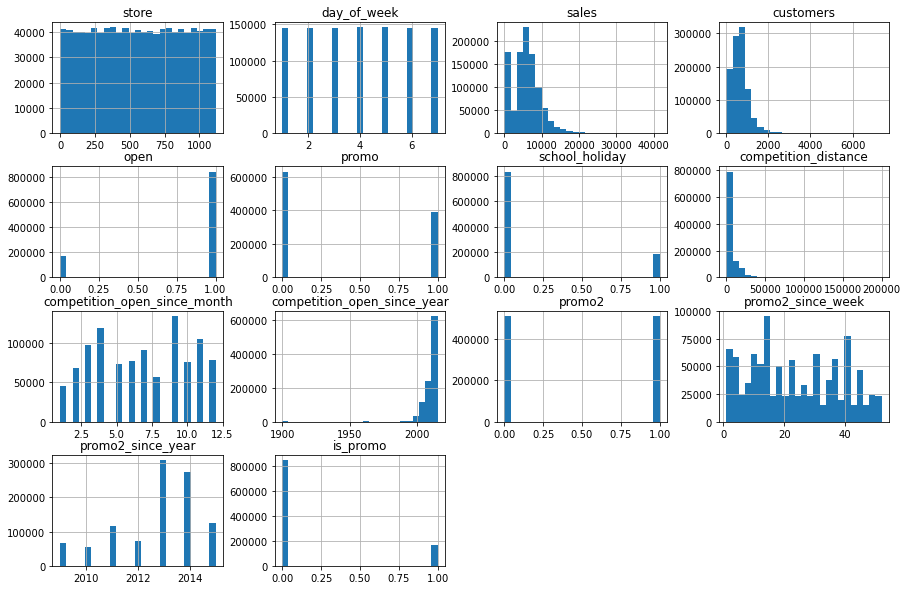

In [32]:
f, ax = plt.subplots(figsize = (15, 10))
num_attributes.hist(bins=25, ax=ax);

### 4.1.3 Categorical variable

In [33]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments wit

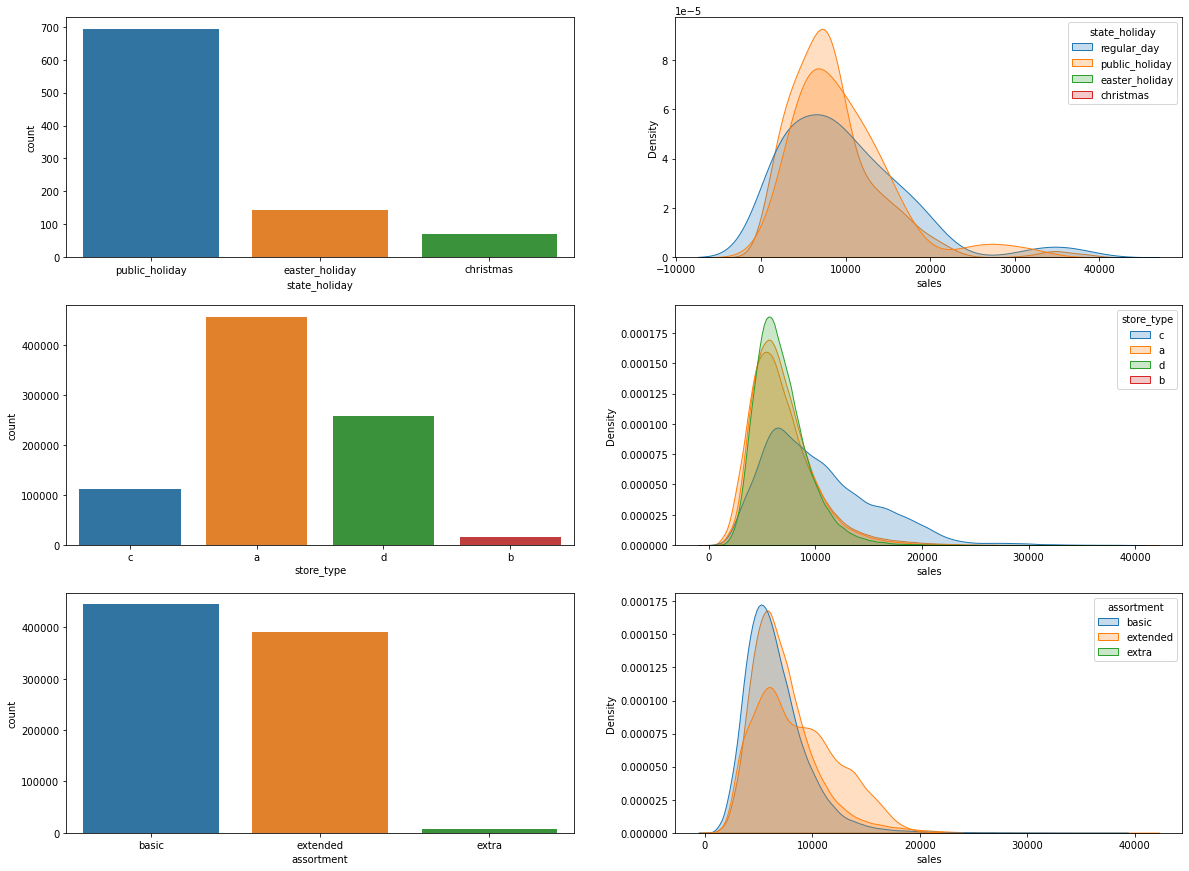

In [34]:
#state_holiday
f, ax = plt.subplots(figsize = (20, 15))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'],label='public_holiday', hue=df4['state_holiday'], shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'],label='easter_holiday', shade=True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'],label='christmas', shade=True);


#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type']);

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label="a", hue=df4['store_type'], shade=True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label="b", shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label="c", shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label="d", shade=True)


#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], hue=df4['assortment'], shade=True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], shade=True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], shade=True);

## 4.2 Análise Bivariada

### **H1** Lojas com maior número de funcionários deveriam vender mais.
**FALSA** Lojas com maior sortimento vendem menos.

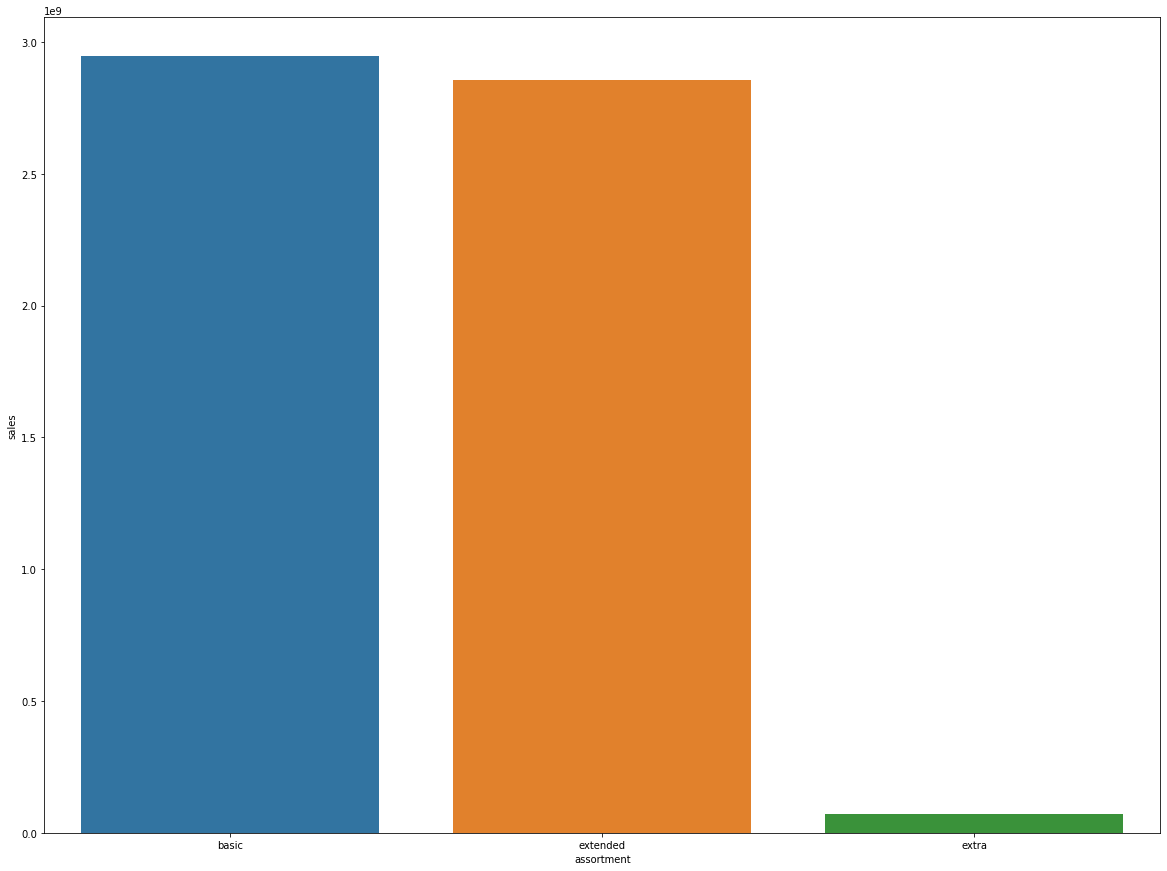

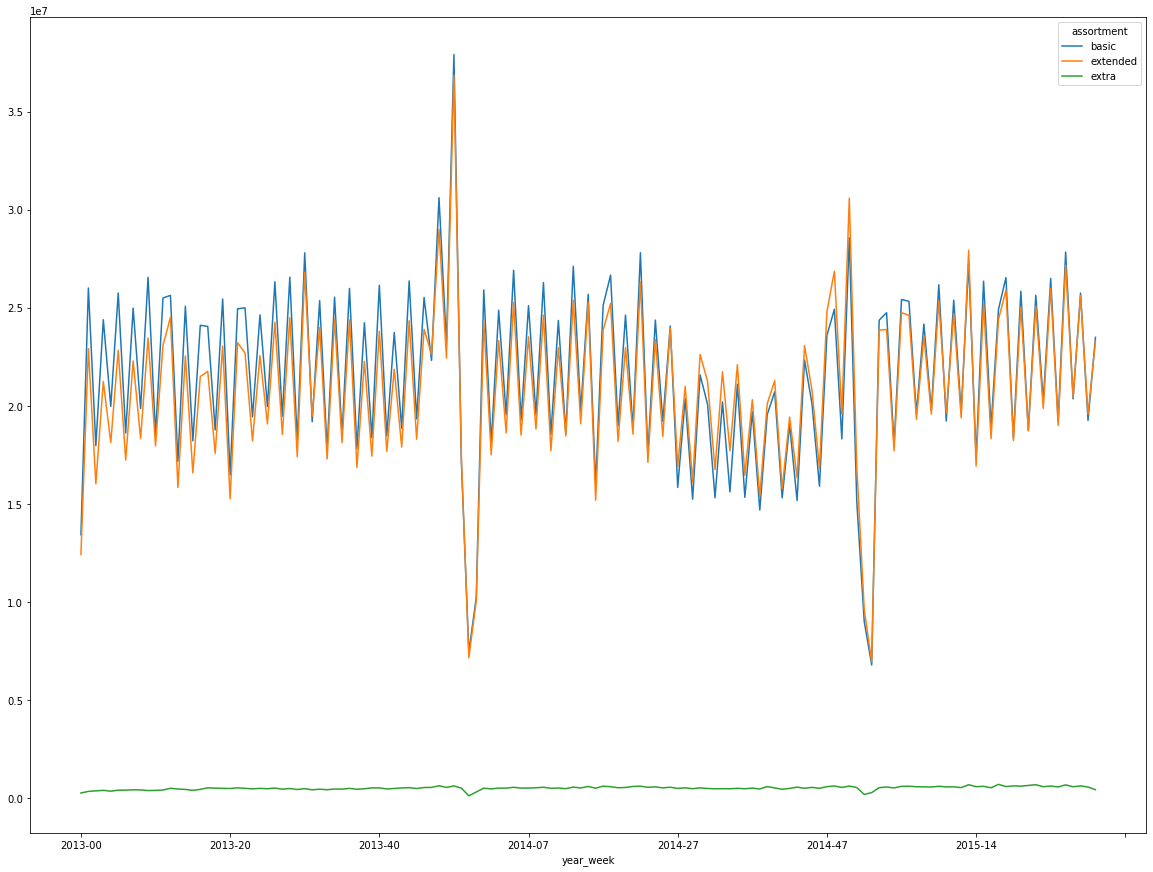

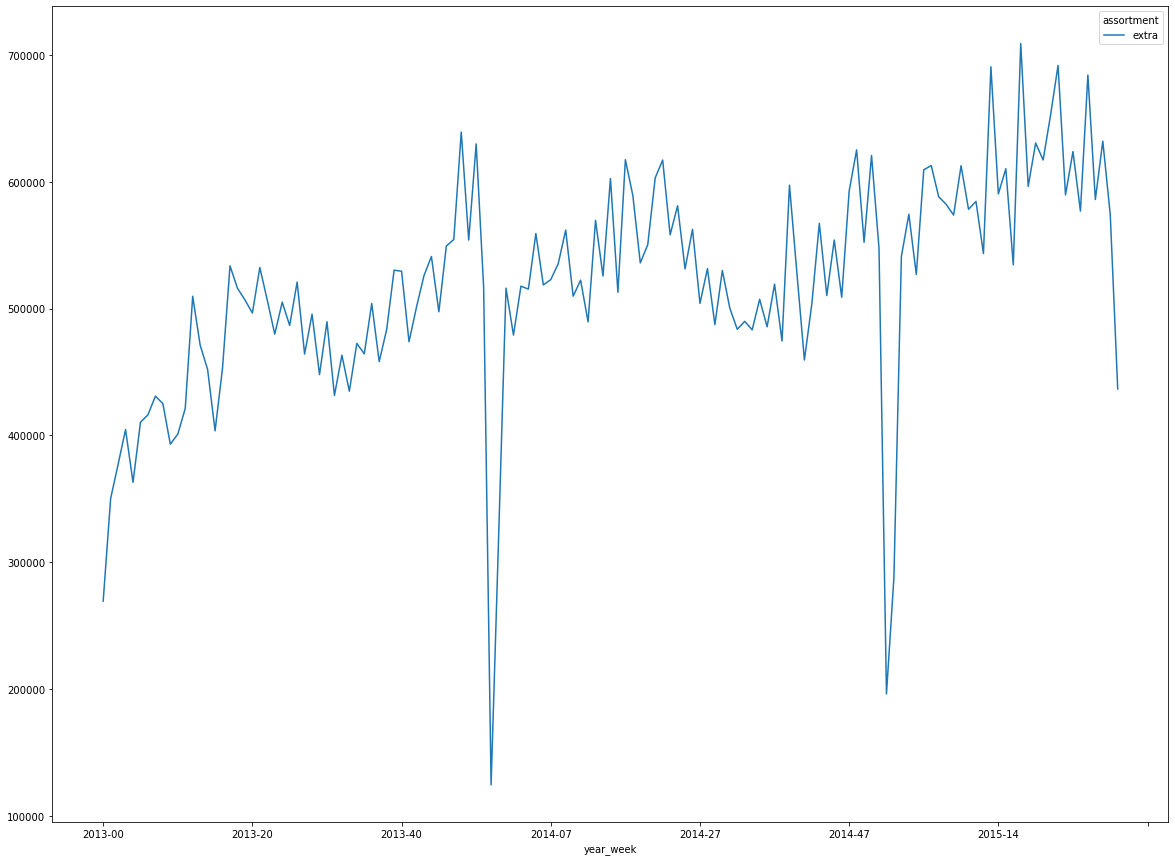

In [35]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
sns.barplot(x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,15));

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(20,15));

### **H2** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos vendem mais

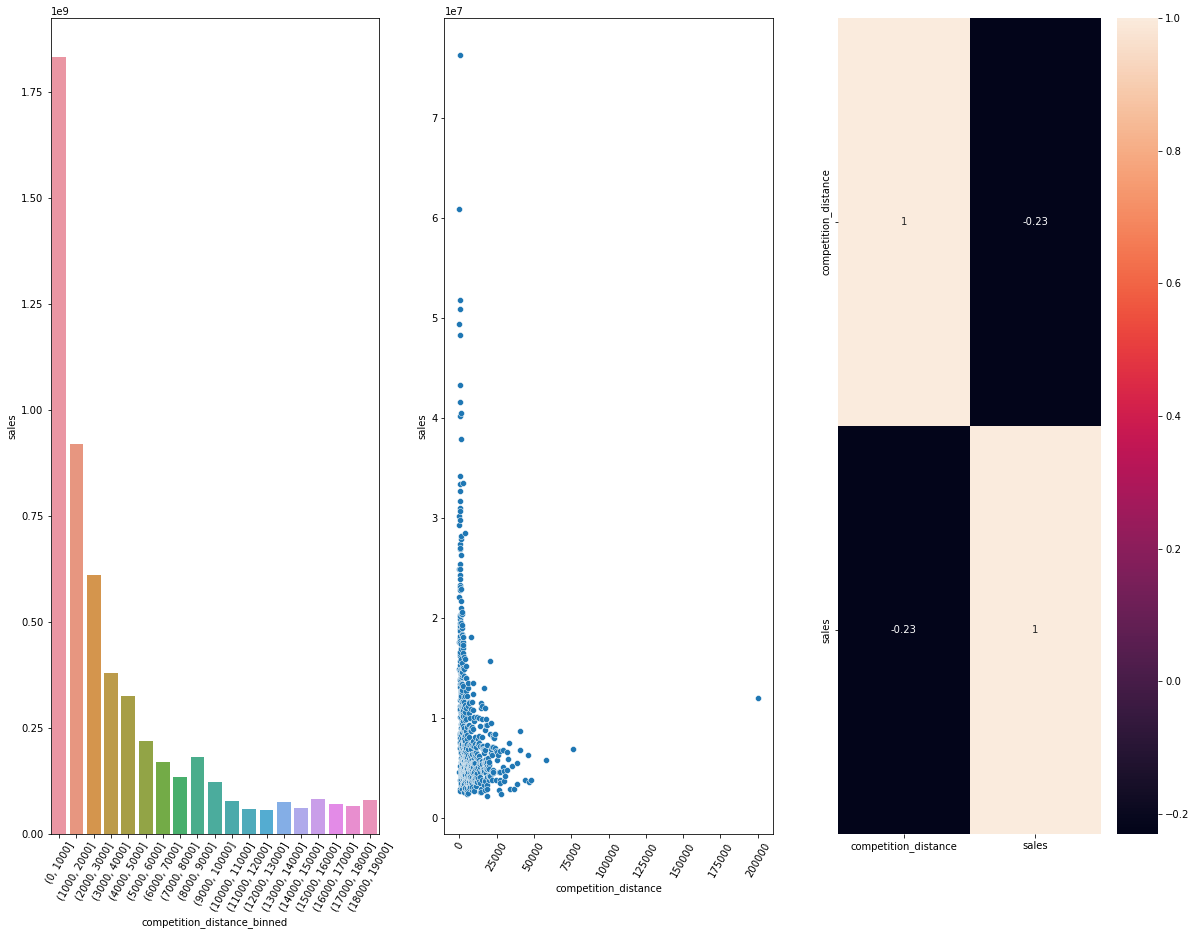

In [36]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

## Gráfico de barras
fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
plt.xticks(rotation=60)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

## Gráfico de pontos (scatter)
plt.subplot(1,3,2)
plt.xticks(rotation=60)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

## Mapa de calor
plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3** Lojas com competidores a mais tempo deveriam vender mais.
**FALSA** Lojas com competidores a mais tempo vendem menos

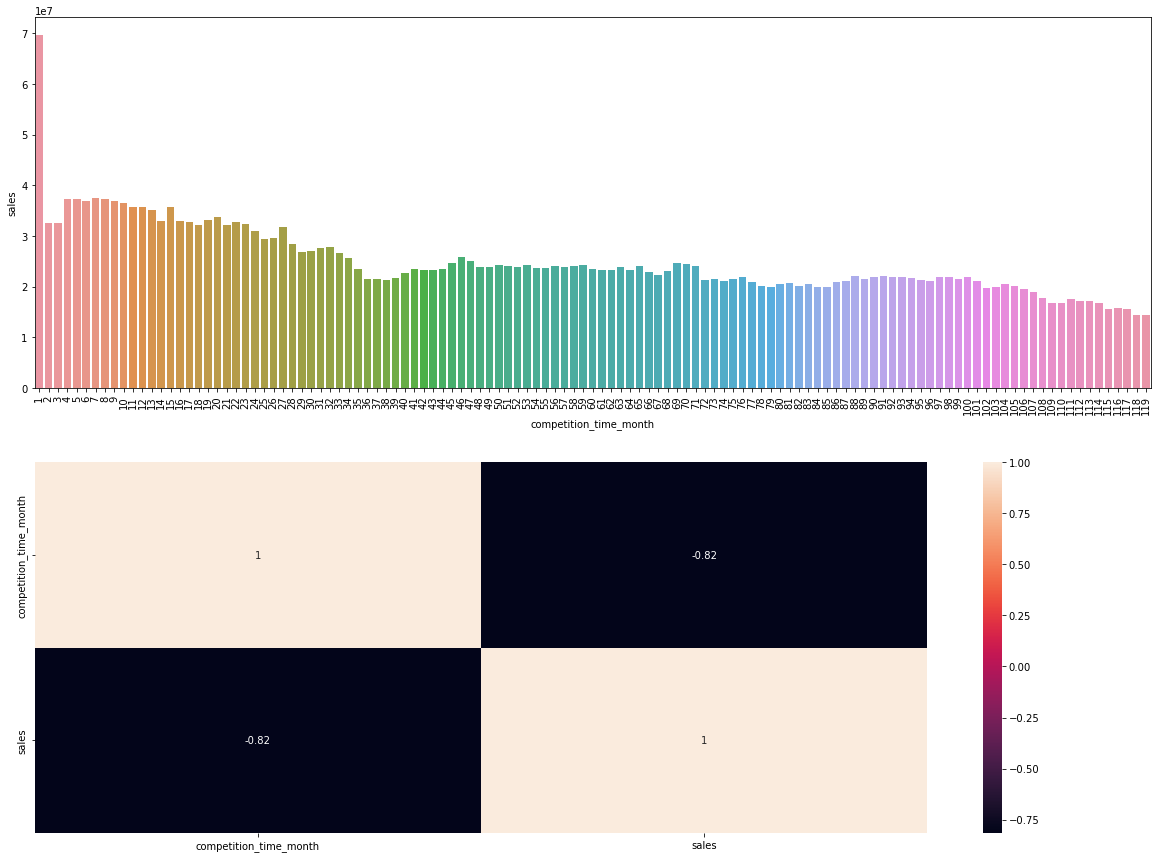

In [37]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] > 0)]

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(2, 1, 1)
plt.xticks(rotation=90)
sns.barplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(2, 1, 2)
sns.heatmap(aux2.corr('pearson'), annot=True);

### **H4** Lojas com promoções ativas por mais tempo deveriam vender mais
**FALSA** Lojas com mpromoções ativas por mais tempo vendem menos

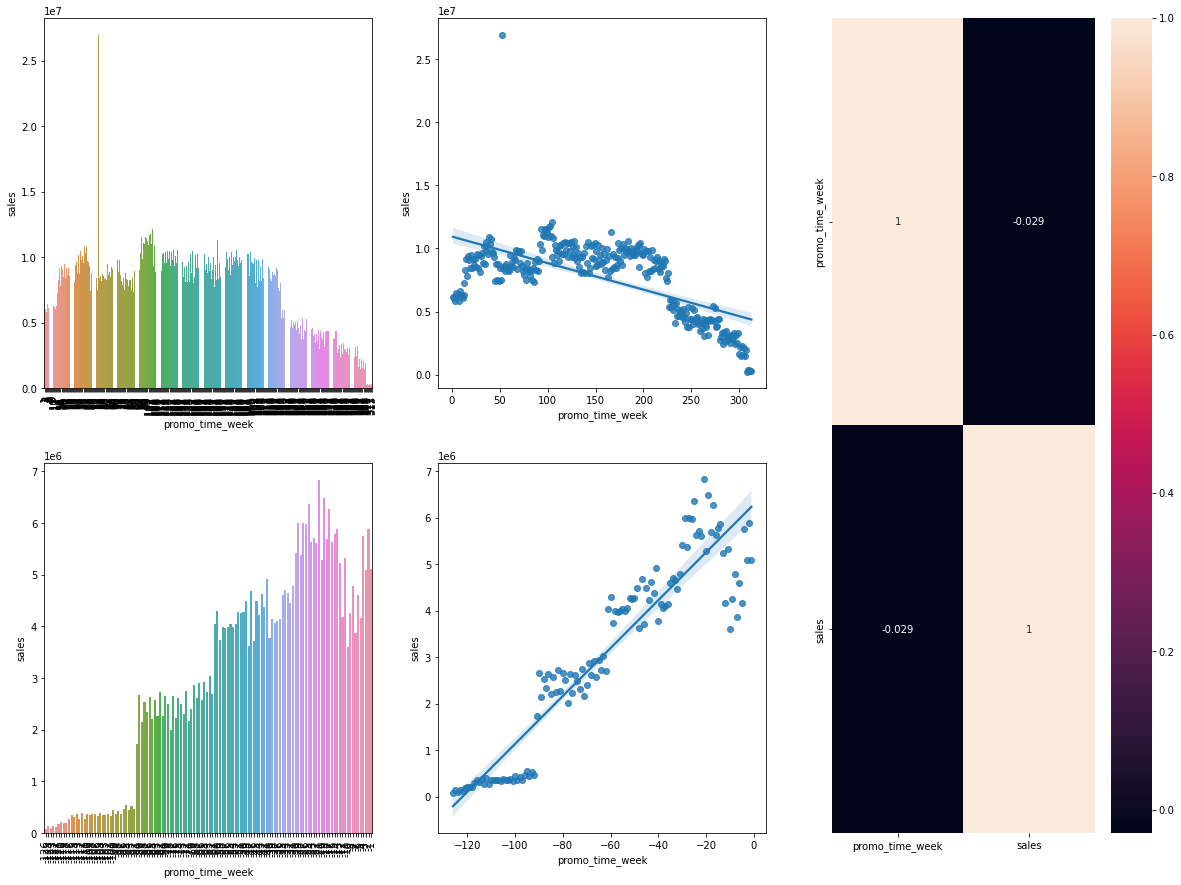

In [38]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2, 3)

## Separação em períodos
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(grid[0,0])
plt.xticks(rotation=90);
sns.barplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2); # Verifica a tendência da variável


aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
plt.subplot(grid[1,0])
plt.xticks(rotation=90);
sns.barplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3); # Verifica a tendência da variável

# Mapa de calor
plt.subplot(grid[:, 2])
sns.heatmap(aux1.corr('pearson'), annot=True);

## É possível observar com os gráficos abaixo que em uma promoção, as vendas têm um volume maior até certo período após o início
## Além disso, promoções futuras resulta em um aumento nas vendas quando o período de início da promoção está próximo.

### <s> **H5** Lojas com mais dias de promoção deveriam vender mais </s>

Devido a similaridade com a hipótese 4, será respondida no próximo ciclo do CRISP.

### **H6** Lojas com mais promoções consecutivas deveriam vender mais
**FALSA** Lojas com mais promoções consecutivas vendem menos.

In [39]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


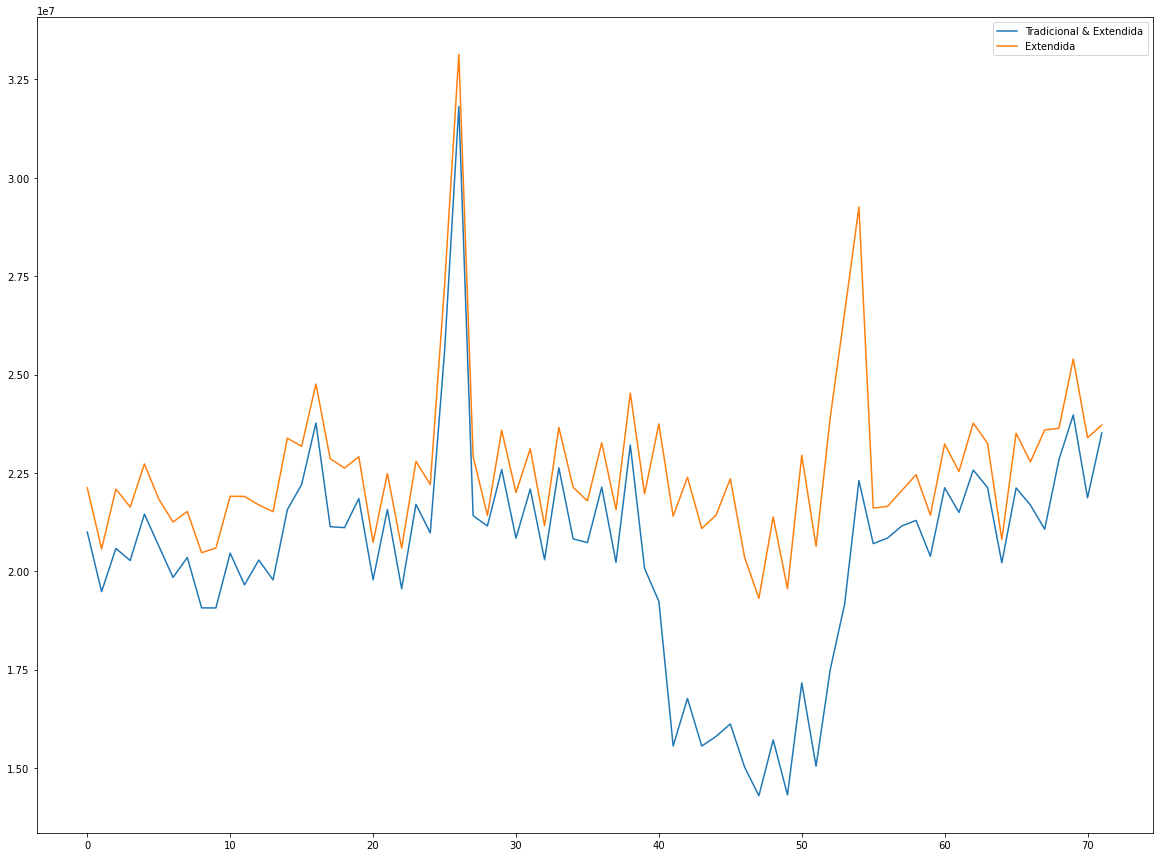

In [40]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
fig, ax = plt.subplots(figsize=(20,15))
aux1.plot(ax=ax)

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

### **H7** Lojas abertas durante o feriado de Natal deveriam vender mais
**FALSA** Lojas abertas no Natal vendem menos

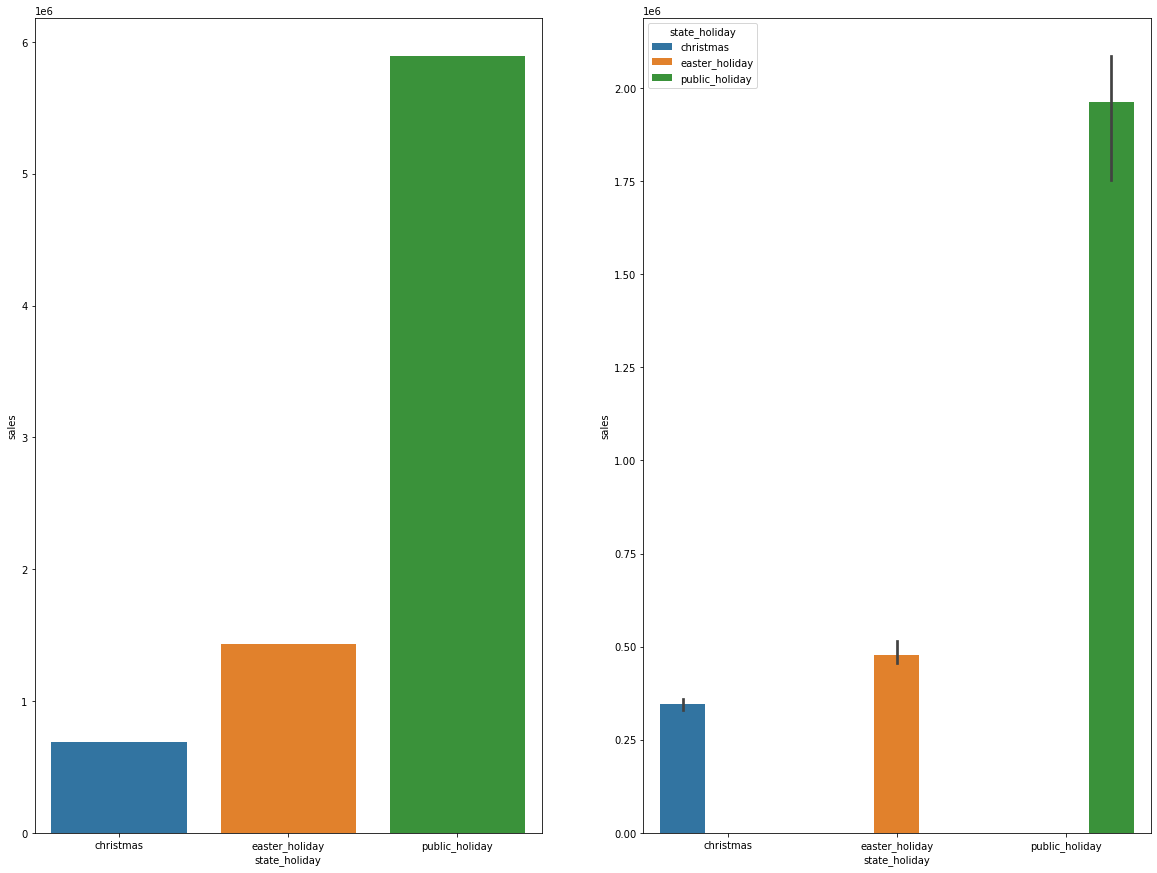

In [41]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig, ax = plt.subplots(figsize=(20,15))

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);


plt.subplot(1,2,2)
aux2 = aux[['state_holiday', 'year', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='state_holiday', y='sales', hue='state_holiday', data=aux2);

### **H8** Lojas deveriam vender mais ao longo dos anos
**FALSA** Lojas vendem menos ao longo dos anos

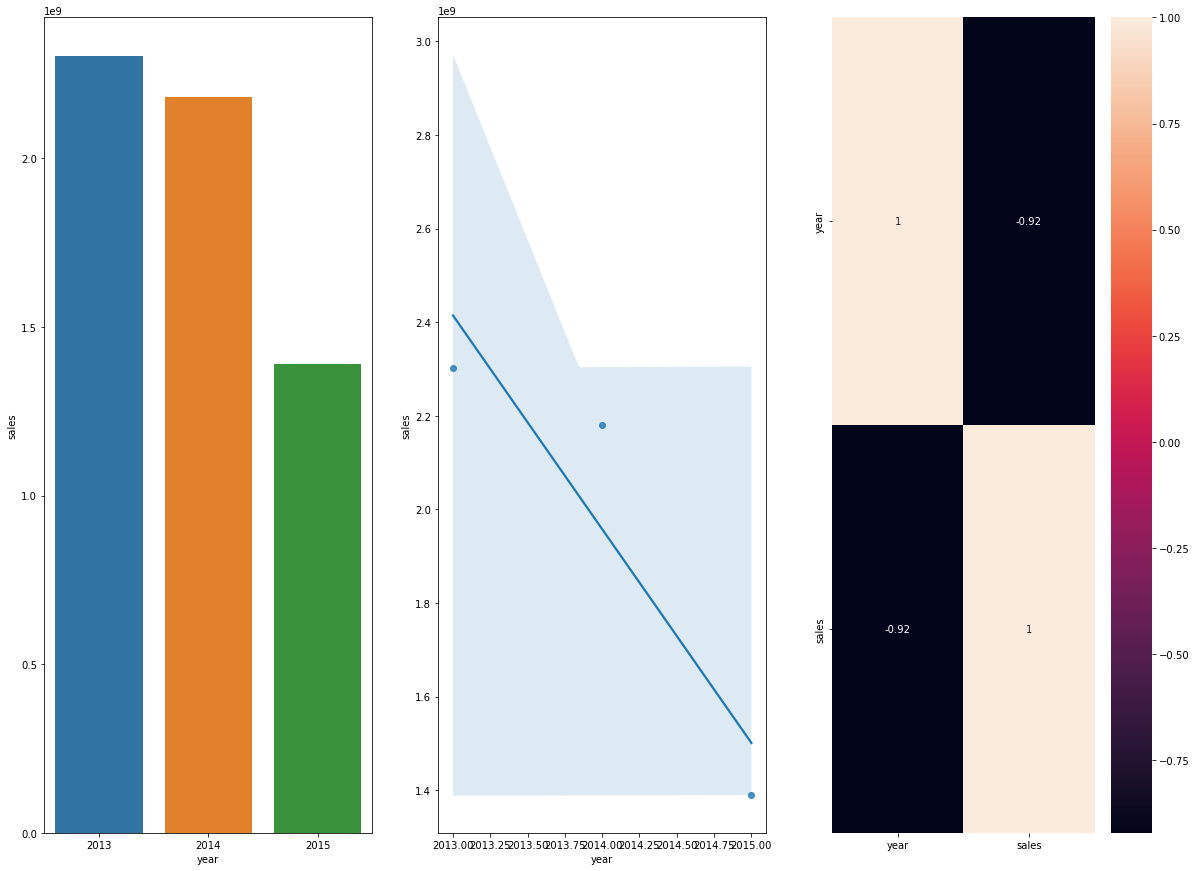

In [42]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### **H9** Lojas deveriam vender mais no segundo semestre do ano
**FALSA** Lojas vendem menos no segundo semestre do ano

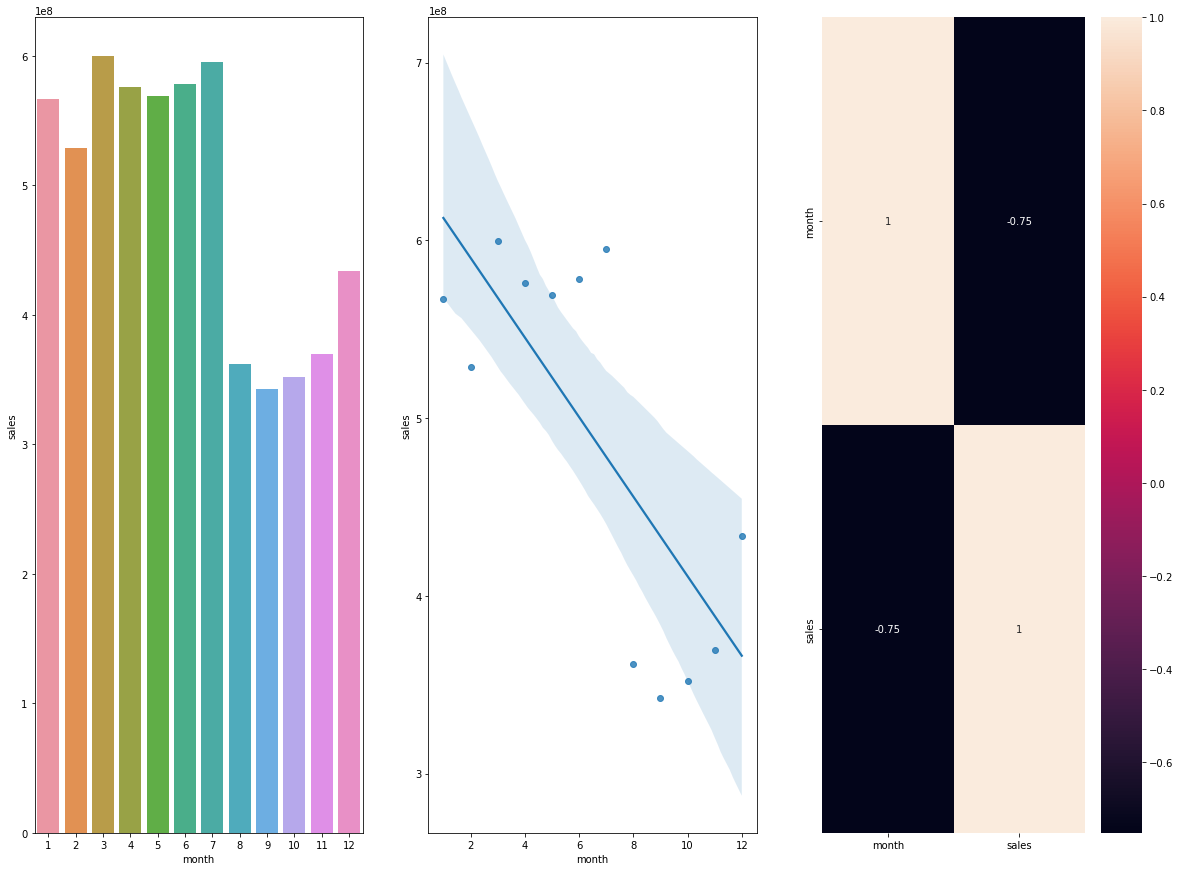

In [43]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### **H10** Lojas deveriam vender mais depois do dia 10 de cada mês
**VERDADEIRO**

In [44]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10th_day' if x < 10 else 'after_10th_day')

aux1.head(15)

,day,sales,before_after
0,1,155983560,before_10th_day
1,2,233513169,before_10th_day
2,3,194582812,before_10th_day
3,4,228301010,before_10th_day
4,5,212869176,before_10th_day
5,6,197094539,before_10th_day
6,7,201380487,before_10th_day
7,8,189718770,before_10th_day
8,9,175922427,before_10th_day
9,10,181039363,after_10th_day


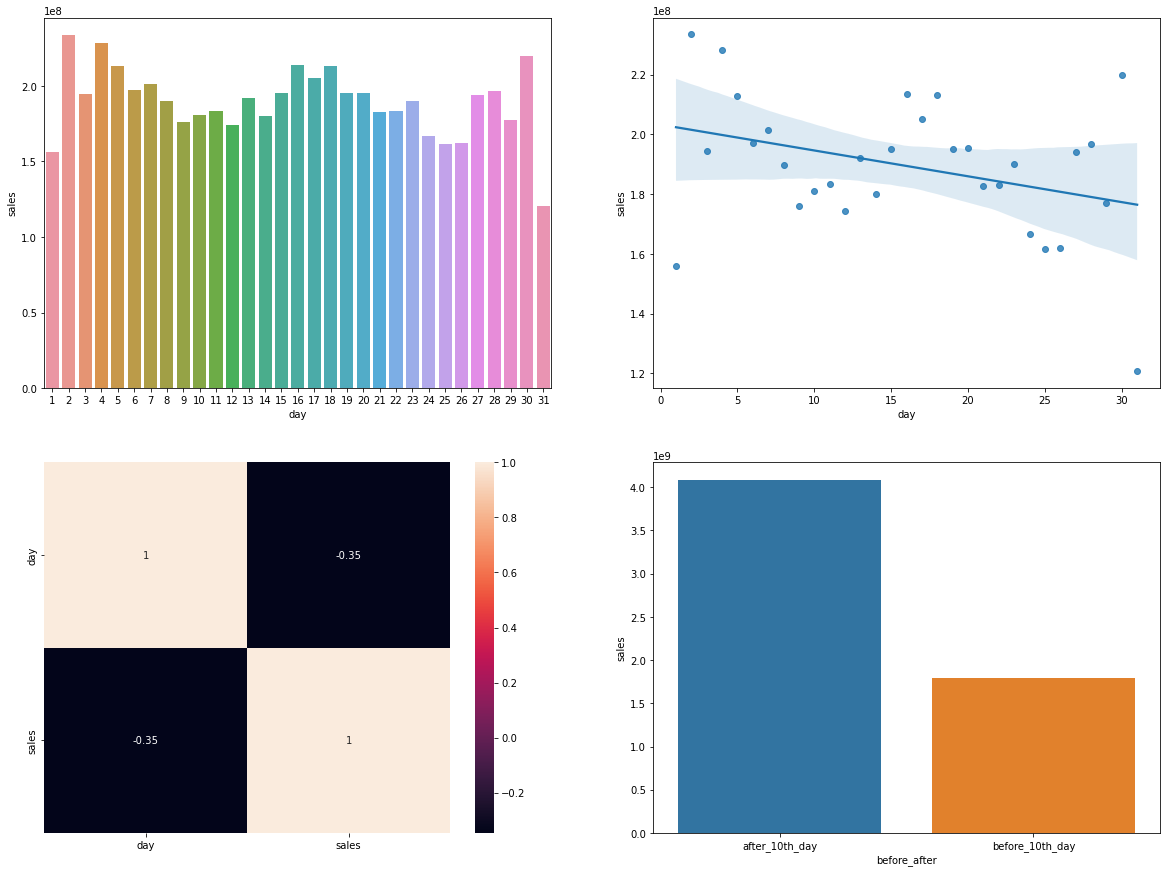

In [45]:
fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

plt.subplot(2,2,4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11** Lojas deveriam vender menos aos finais de semana
**VERDADEIRO**

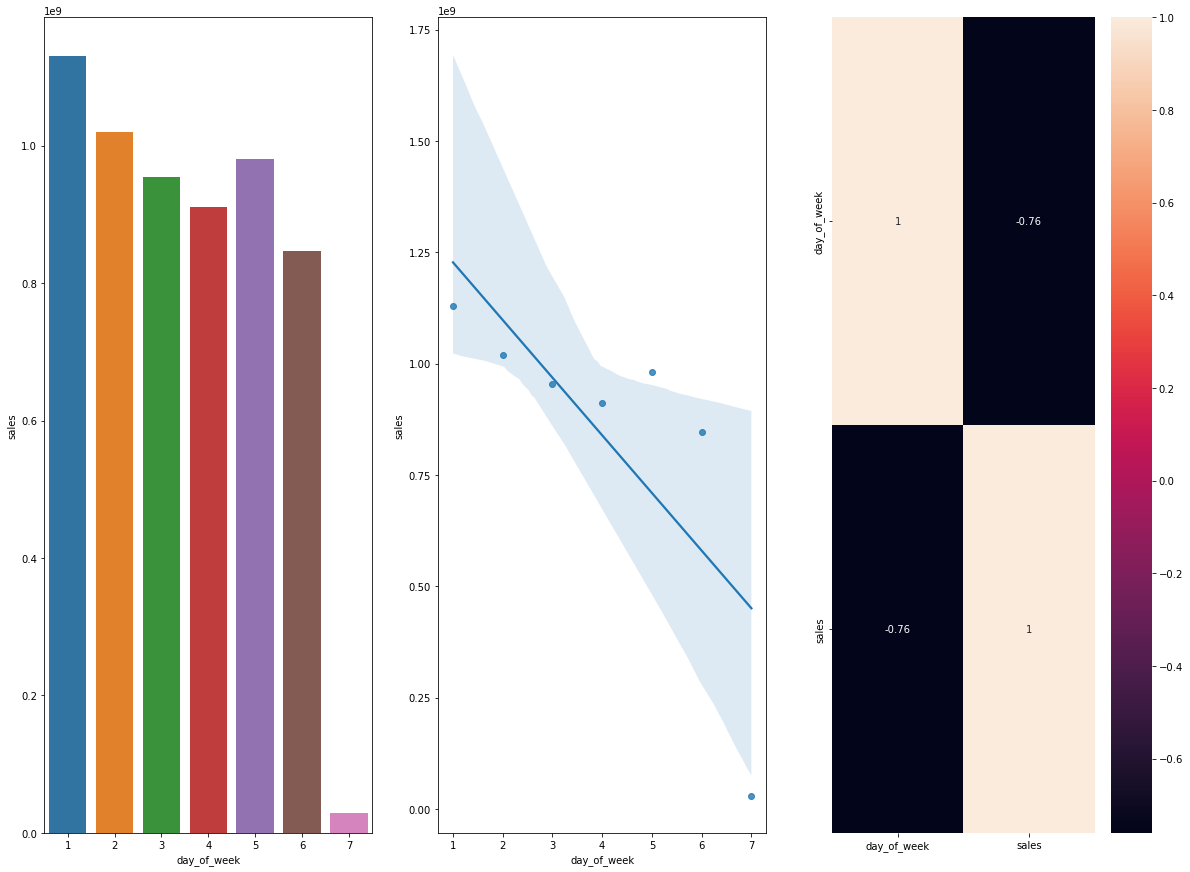

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### **H12** Lojas deveriam vender menos durante os feriados escolares
**VERDADEIRO** Exceto para o mês de agosto.

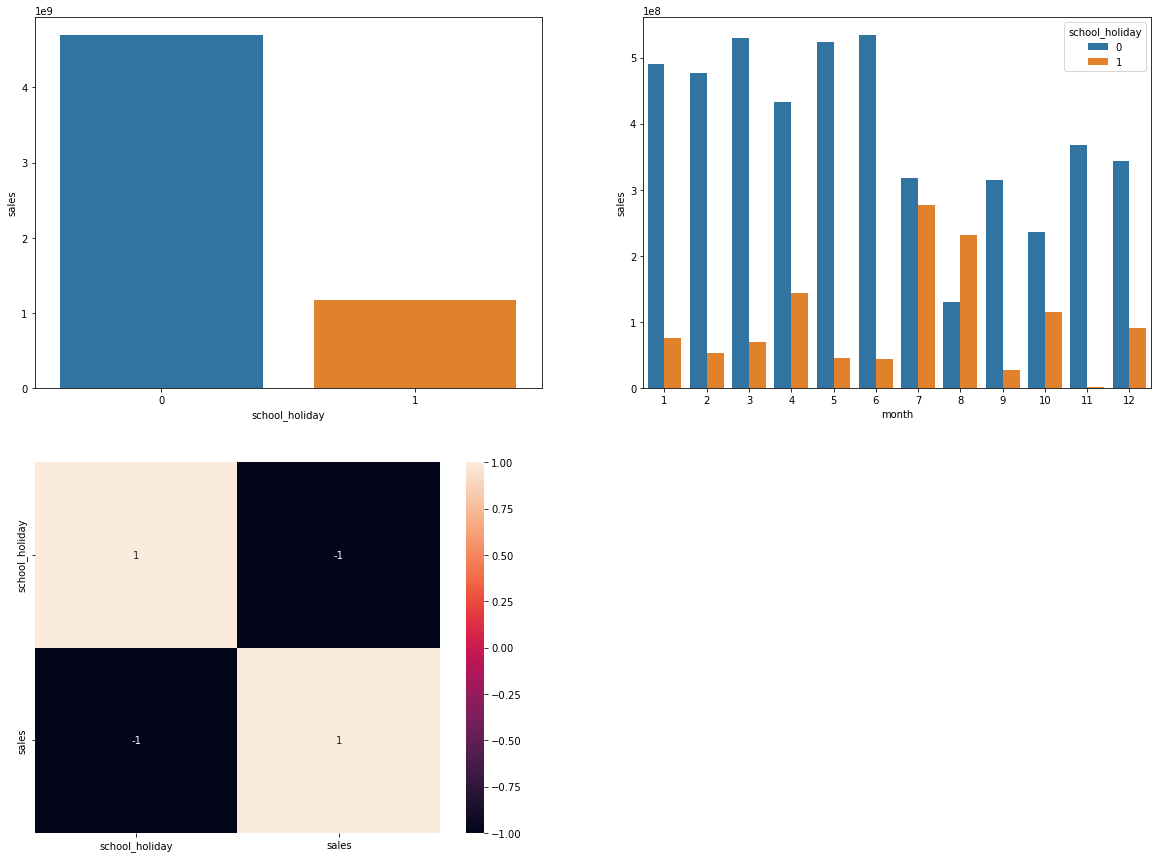

In [47]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

fig, ax = plt.subplots(figsize=(20,15))
plt.subplot(2,2,1)
sns.barplot(x='school_holiday', y='sales', data=aux1);


aux2 = df4[['school_holiday', 'month', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,2,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr('pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses

In [48]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Média'],
      ['H3', 'Falsa', 'Média'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Média'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipótese    Conclusão    Relevância
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Média
H3          Falsa        Média
H4          Falsa        Baixa
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Média
H8          Falsa        Alta
H9          Falsa        Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

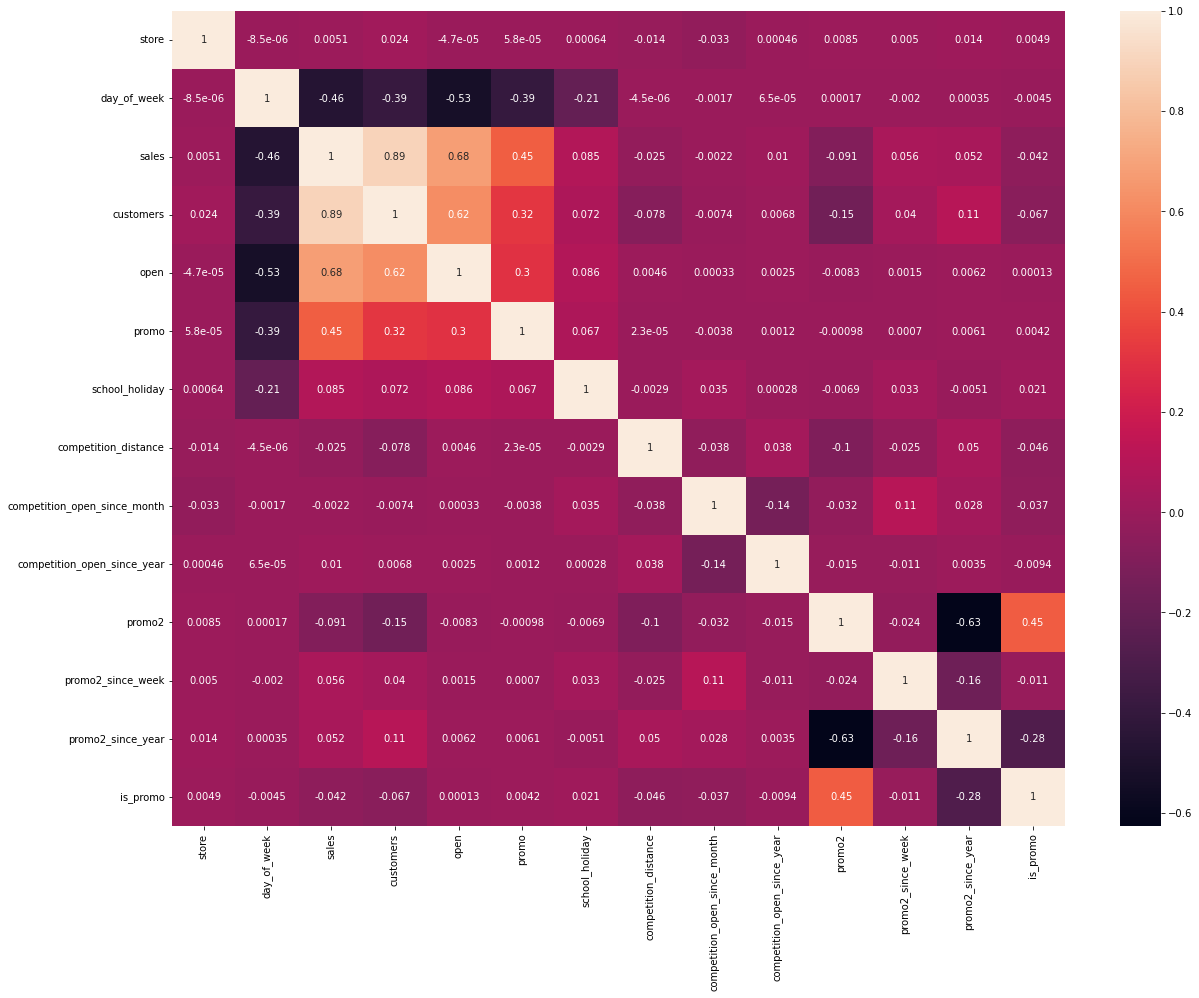

In [49]:
correlation = num_attributes.corr(method='pearson')

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

In [50]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate Cramer V
a1 = crammer_v(a['state_holiday'], a['state_holiday'])
a2 = crammer_v(a['state_holiday'], a['store_type'])
a3 = crammer_v(a['state_holiday'], a['assortment'])

a4 = crammer_v(a['store_type'], a['state_holiday'])
a5 = crammer_v(a['store_type'], a['store_type'])
a6 = crammer_v(a['store_type'], a['assortment'])

a7 = crammer_v(a['assortment'], a['state_holiday'])
a8 = crammer_v(a['assortment'], a['store_type'])
a9 = crammer_v(a['assortment'], a['assortment'])


# Final dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
             'store_type': [a4, a5, a6],
             'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

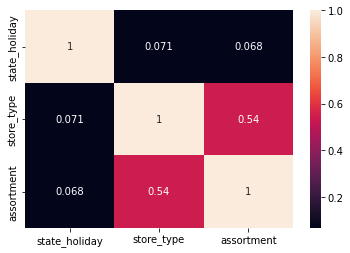

In [51]:
sns.heatmap(d, annot=True);

# 5.0. PASSO 5 - DATA PREPARATION

In [52]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

In [53]:
# Checagem das variáveis

lista_a = df5.select_dtypes(include=['int64', 'float64'])

In [54]:
lista_a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4


C:\Users\joao\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


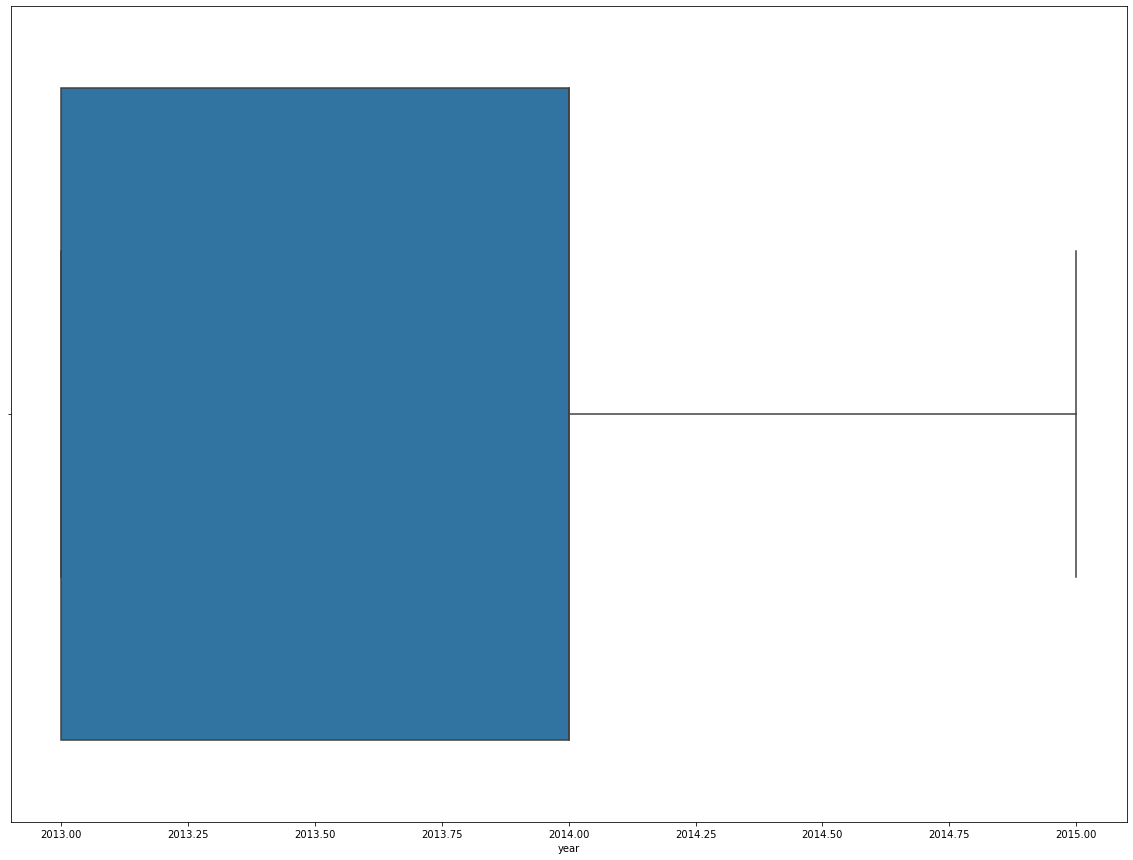

In [55]:
fig,ax = plt.subplots(figsize=(20,15))

sns.boxplot(df5['year']);

In [56]:
# Instanciando as classes
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


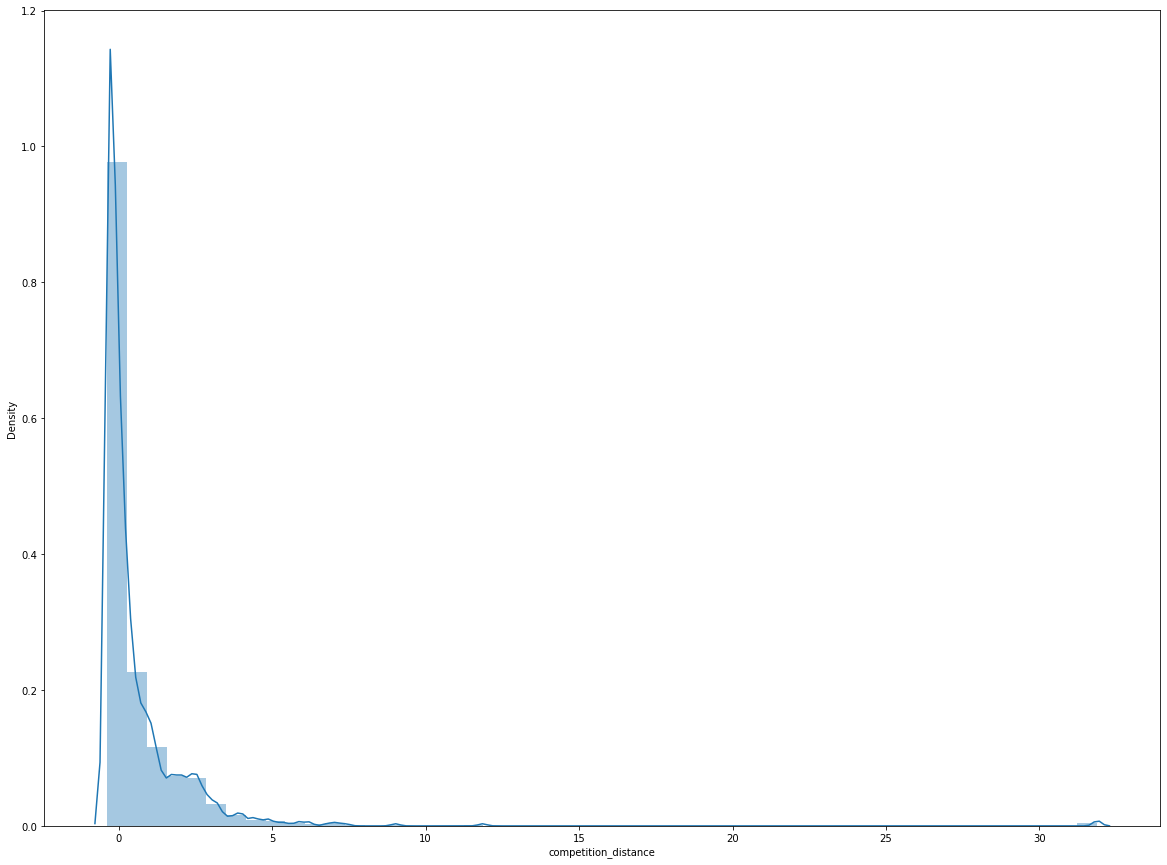

In [57]:
fig,ax = plt.subplots(figsize=(20,15))

sns.distplot(df5['competition_distance']);

## 5.3. Transformação

### 5.3.1. Encoding

In [58]:
# store_holiday -> devido a característica dessa variável (ou o dia é um dia normal ou um feriado) utiliza-se o one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type -> não há como saber se "a" é maior que "b" ou "c"... logo, usamos label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment -> sabemos que basic é menor que extend e extra, por isso usamos o ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Transformação da Variável Resposta

In [59]:
df5['sales'] = np.log1p(df5['sales'])

C:\Users\joao\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


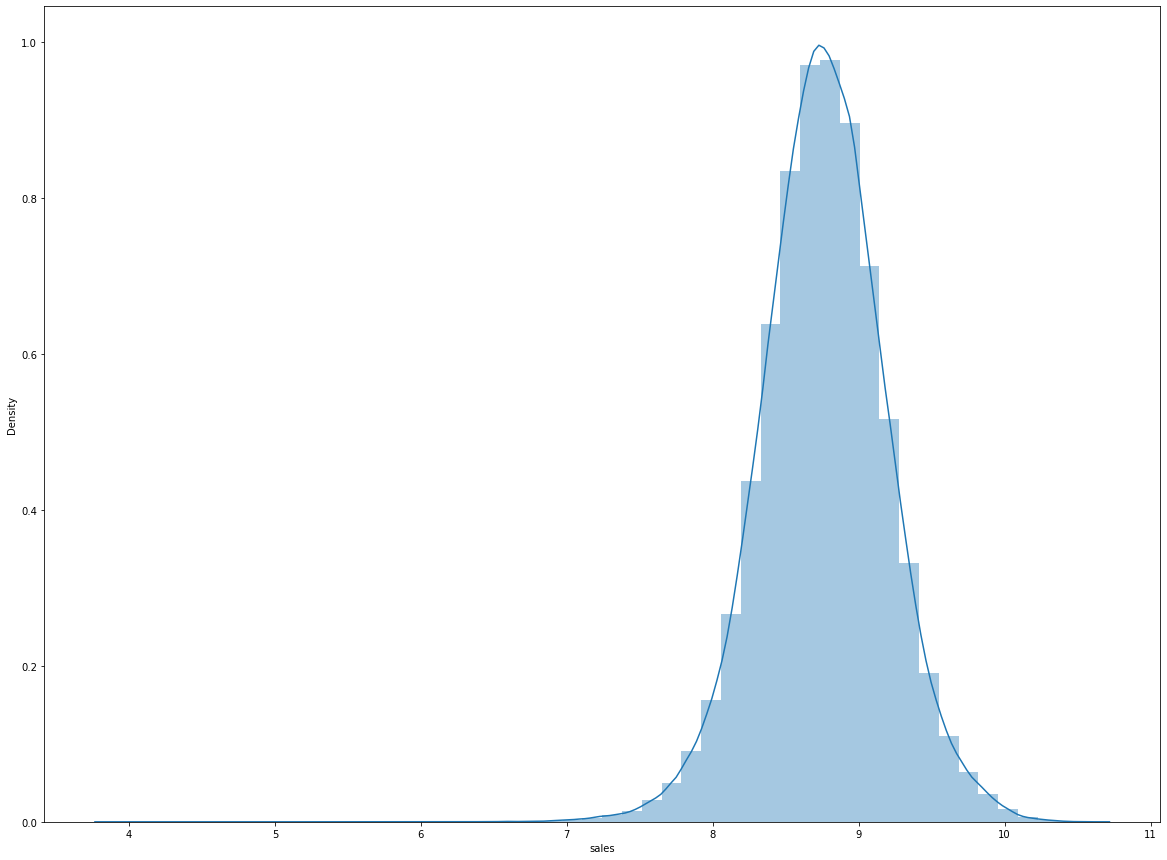

In [60]:
fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(df5['sales']);

### 5.3.3. Transformação de Natureza

In [61]:
# Variáveis de natureza cíclica:

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x* (2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x* (2*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x* (2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x* (2*np.pi/30)))


# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x* (2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x* (2*np.pi/52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x* (2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x* (2*np.pi/7)))


In [62]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0. PASSO 06 - SELEÇÃO DE VARIÁVEIS

In [63]:
df6 = df5.copy()

## 6.1. Separando o dataframe em teste e treino

In [64]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [65]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

Nesse ponto, será separado o dataset em treino e teste. Para isso, será escolhido até 6 semanas antes da última data que está no dataset para servir de treino e após essa data, será utilizado como teste.

In [66]:
# Agrupamento
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [67]:
# Dados de treino
X_train = df6[df6['date'] < '2015-06-19'] 
y_train = X_train['sales']

# Dados de teste
X_test = df6[df6['date'] >= '2015-06-19'] 
y_test = X_test['sales']

print('Training min date: {}'.format(X_train['date'].min()))
print('Training max date: {}'.format(X_train['date'].max()))

print('Training min date: {}'.format(X_test['date'].min()))
print('Training max date: {}'.format(X_test['date'].max()))

Training min date: 2013-01-01 00:00:00
Training max date: 2015-06-18 00:00:00
Training min date: 2015-06-19 00:00:00
Training max date: 2015-07-31 00:00:00


## 6.2. Boruta como selecionador de variáveis

In [68]:
# Dataset de treinamento e teste para o Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()
#
## Instanciando a Random Forest
#rf = RandomForestRegressor(n_jobs=-1) # o valor de -1 serve pra usar todos os cores/núcleos na máquina
#
#
## Definindo Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2).fit(X_train_n, y_train_n)

O método suport_ serve para rankear as variáveis de acordo com a sua relevância, exemplo, caso uma coluna apresentada tenha o valor 3, é porque ela é a terceira mais importante em relação a varoável resposta. Se for 1, ela é a primeira mais relevante.

Portanto, quanto menor for o número, melhor!

### 6.2.1. Melhores variáveis segundo o Boruta

In [69]:
#cols_selected = boruta.support_.tolist()
#
## Melhores variáveis
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## Não selecionado pelo Boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [70]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_cos',
    'month_sin',
    'day_sin',
    'day_cos',
    'week_of_year_cos',
    'week_of_year_sin',
    'day_of_week_sin',
    'day_of_week_cos']

#columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [71]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

# 7.0. PASSO 07 - MACHINE LEARNING MODELING

## 7.1. Average Model

In [72]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

In [73]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['sales', 'store']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


In [74]:
aux1.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_cos,month_sin,day_sin,day_cos,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,8.568646,8.373392
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,8.710290,8.460676
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,9.025816,8.795885
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,9.546527,9.194715
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.866025,-0.5,0.207912,0.978148,-0.822984,-0.568065,-0.974928,-0.222521,8.481151,8.346624


## 7.2. Linear Regression Model

In [75]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1. Linear Regression Model - Cross Validation

In [76]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)

In [77]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [78]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train) #alpha serve para multiplicar os pesos e deixar entre um range desejado

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1891.70488,0.289106,2744.451735


### 7.3.1. Lasso - Cross Validation

In [79]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [80]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
# n_estimators é o número de árvores que o modelo irá criar.
# n_jobs = -1 serve para deixar ele trabalhando em paralelo com os núcleos.
# random_state é a origem dos números aleatórios, nesse caso pode ser qqer número.

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.548994,0.099664,1007.858486


### 7.4.1. Random Forest Regressor - Cross Validation

In [81]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv


KeyboardInterrupt



## 7.5. XGBoost Regressor

In [87]:
import xgboost as xgb

In [88]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9).fit(x_train, y_train)

#objective -> é a função objetivo
#eta -> quantas passadas usa para fazer o aprendizado
#max_depth -> qual a profundidade/ramificação máxima que uma arvore pode chegar
#subsample -> % de todas as variáveis que queremos fazer a amostragem para selecioanr as variáveis mais importantes
#colsample_bytree -> são várias arvores e faz a combinação entre essas arvores

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regression', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[16:16:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regression,6683.602213,0.949501,7330.746126


### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.6. Compare Model Performances


### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

### 7.6.1. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

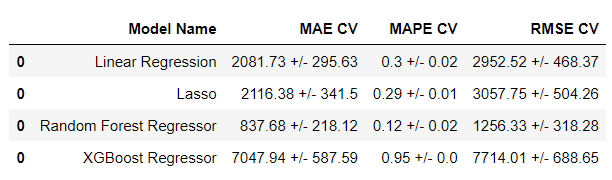

In [84]:
Image('images/real_performance.png')

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [85]:
import random
import warnings
warnings.filterwarnings('ignore')

In [90]:
# Criando o dicionário
param = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytee': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15] }

MAX_EVAL = 2

In [91]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    #choose values for parameters ramdomly
    
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    
    # ============================================================================================= #
    
    # Em cima, está sendo dito ao código que "para cada valor 'v' em uma chave 'k' que
    # está em 'param.items()', escolher aleatóriamente um valor através do método .sample(v, 1)[0]
    # guardar em uma chave 'k' e por fim, guardar esse valor em um dicionário final 'hp'."
    
    # ============================================================================================= #
    
    
    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytee'],
                                 min_child_weight=hp['min_child_weight'])
    
    # Aqui os valores dos parâmetros serão passados em forma de lista
    
    # performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
    final_result = pd.concat([final_result, result])
    
final_result

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytee': 0.3, 'min_child_weight': 3}
[16:18:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:37:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


{'n_estimators': 3000, 'eta': 0.03,

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1200.02 +/- 41.94,0.16 +/- 0.0,1769.35 +/- 83.9
0,XGBoost Regressor,914.67 +/- 73.68,0.12 +/- 0.01,1311.68 +/- 128.13


## 8.2. Final Model

In [93]:
# Criando o dicionário
param_tuned = {
    'n_estimators': 30,
    'eta': 0.03,
    'max_depth': 9,
    'subsample': 0.1,
    'colsample_bytee': 0.7,
    'min_child_weight': 15}


In [94]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param_tuned['n_estimators'],
                                   eta=param_tuned['eta'],
                                   max_depth=param_tuned['max_depth'],
                                   subsample=param_tuned['subsample'],
                                   colsample_bytee=param_tuned['colsample_bytee'],
                                   min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# Prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[21:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6763.341807,0.961845,7410.272249
